In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import scipy
import pandas as pd
from tqdm import tqdm


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('style.mcstyle')

In [3]:
import torch
from torch import nn
import sbi
from sbi import utils as utils
from sbi.inference import likelihood_estimator_based_potential

In [4]:
from tools.catalog import Catalog
from tools.plot_tools import binned_plot
get_cen = lambda edges: np.array([(edges[i]+edges[i+1])/2. for i in range(len(edges)-1)])

# Andrea Flagship 2 data (old)

In [9]:
data = pd.read_csv('data/raw/deep_all.dat', delimiter=' ', index_col=False,
                   skipinitialspace=True)
data = pd.DataFrame(data.iloc[1:,:-1].values, columns=data.columns[1:]).reset_index(drop=True)

/var/folders/_t/p68l7m6933b26j8g9wkcgq080000gp/T/ipykernel_13409/851058082.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/raw/deep_all.dat', delimiter=' ', index_col=False,


In [10]:
c = 2.99792458e5 # km/s
data['vwC50'] = c*(data['zwerr']-data['zwC50'])/(1+data['zwC50'])
data['vwC100'] = c*(data['zwerr']-data['zwC100'])/(1+data['zwC100'])
data['vdC50'] = c*(data['zwerr']-data['zdC50'])/(1+data['zwC50'])
data['vdC100'] = c*(data['zwerr']-data['zdC100'])/(1+data['zwC100'])

In [7]:
def calc_sum(x):
    feats = [x.sum(axis=0), x.mean(axis=0), x.std(axis=0),
             np.median(x, axis=0), x.min(axis=0), x.max(axis=0), [len(x)]]
    return np.concatenate(feats)

def process_and_save(
    data,
    vname,
    fHa_min,
    dirpath,
    vmin=5000,
    param_names=['M200'],
):
    # mask out high velocity, low fHa data
    mask = np.abs(data[vname]) < vmin
    mask &= data['fHa'] > np.log10(fHa_min)

    # get data
    data_names = ['x','y',vname]
    ids = data.loc[mask,'Cl_id'].values.astype(int)
    gals = data.loc[mask, data_names].values.astype('float64')
    thetas = np.log10(data.loc[mask, param_names].values.astype('float64'))

    # remove singles
    unq, cnt = np.unique(ids, return_counts=True)
    mask = np.isin(ids, unq[cnt>1])
    ids, gals, thetas = ids[mask], gals[mask], thetas[mask]

    # calculate batches
    ids_batch = np.unique(ids)
    x_batch = np.array([gals[ids==i] for i in ids_batch], dtype=object)
    thetas_batch = np.array([thetas[ids==i][0] for i in ids_batch])

    # calculate summaries
    x_sum = np.array([calc_sum(x) for x in x_batch])


    # assign folds
    folddict = pd.Series(np.random.choice(10, size=len(ids_batch)), 
                         index=ids_batch)
    folds = folddict[ids].values

    # make train/test splits
    fold = 0
    mask = folds != fold

    # save
    os.makedirs(dirpath, exist_ok=True)
    np.save(join(dirpath, f'x_train.npy'), gals[mask])
    np.save(join(dirpath, f'x_test.npy'), gals[~mask])
    np.save(join(dirpath, f'theta_train.npy'), thetas[mask])
    np.save(join(dirpath, f'theta_test.npy'), thetas[~mask])

    np.save(join(dirpath, f'ids_train.npy'), ids[mask])
    np.save(join(dirpath, f'ids_test.npy'), ids[~mask])
    np.save(join(dirpath, f'folds.npy'), folds)

    mask = folddict[ids_batch].values != fold
    np.save(join(dirpath, f'x_batch_train.npy'), x_batch[mask])
    np.save(join(dirpath, f'x_batch_test.npy'), x_batch[~mask])
    np.save(join(dirpath, f'x_sum_train.npy'), x_sum[mask])
    np.save(join(dirpath, f'x_sum_test.npy'), x_sum[~mask])
    np.save(join(dirpath, f'theta_batch_train.npy'), thetas_batch[mask])
    np.save(join(dirpath, f'theta_batch_test.npy'), thetas_batch[~mask])

    return gals, thetas, x_batch, x_sum, thetas_batch


In [8]:
# Wide survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vwC50',
    fHa_min=2e-16,
    dirpath='data/processed/FS2wC50',
)
print(gals.shape)

(24120, 3)


In [9]:
# Wide survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vwC100',
    fHa_min=2e-16,
    dirpath='data/processed/FS2wC100',
)
print(gals.shape)

(24452, 3)


In [10]:
# Deep survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vdC50',
    fHa_min=6e-17,
    dirpath='data/processed/FS2dC50',
)
print(gals.shape)

(127937, 3)


In [11]:
# Deep survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    'vdC100',
    fHa_min=6e-17,
    dirpath='data/processed/FS2dC100',
)
print(gals.shape)

(128066, 3)


In [16]:
print('gals.shape:', gals.shape)
print('thetas.shape:', thetas.shape)
print('x_batch.shape:', x_batch.shape)
print('x_sum.shape:', x_sum.shape)
print('thetas_batch.shape:', thetas_batch.shape)

print(f'thetas: {thetas.min()} - {thetas.max()}')

gals.shape: (128066, 3)
thetas.shape: (128066, 1)
x_batch.shape: (1000,)
x_sum.shape: (1000, 19)
thetas_batch.shape: (1000, 1)
thetas: 13.93499306319521 - 14.79519850915429


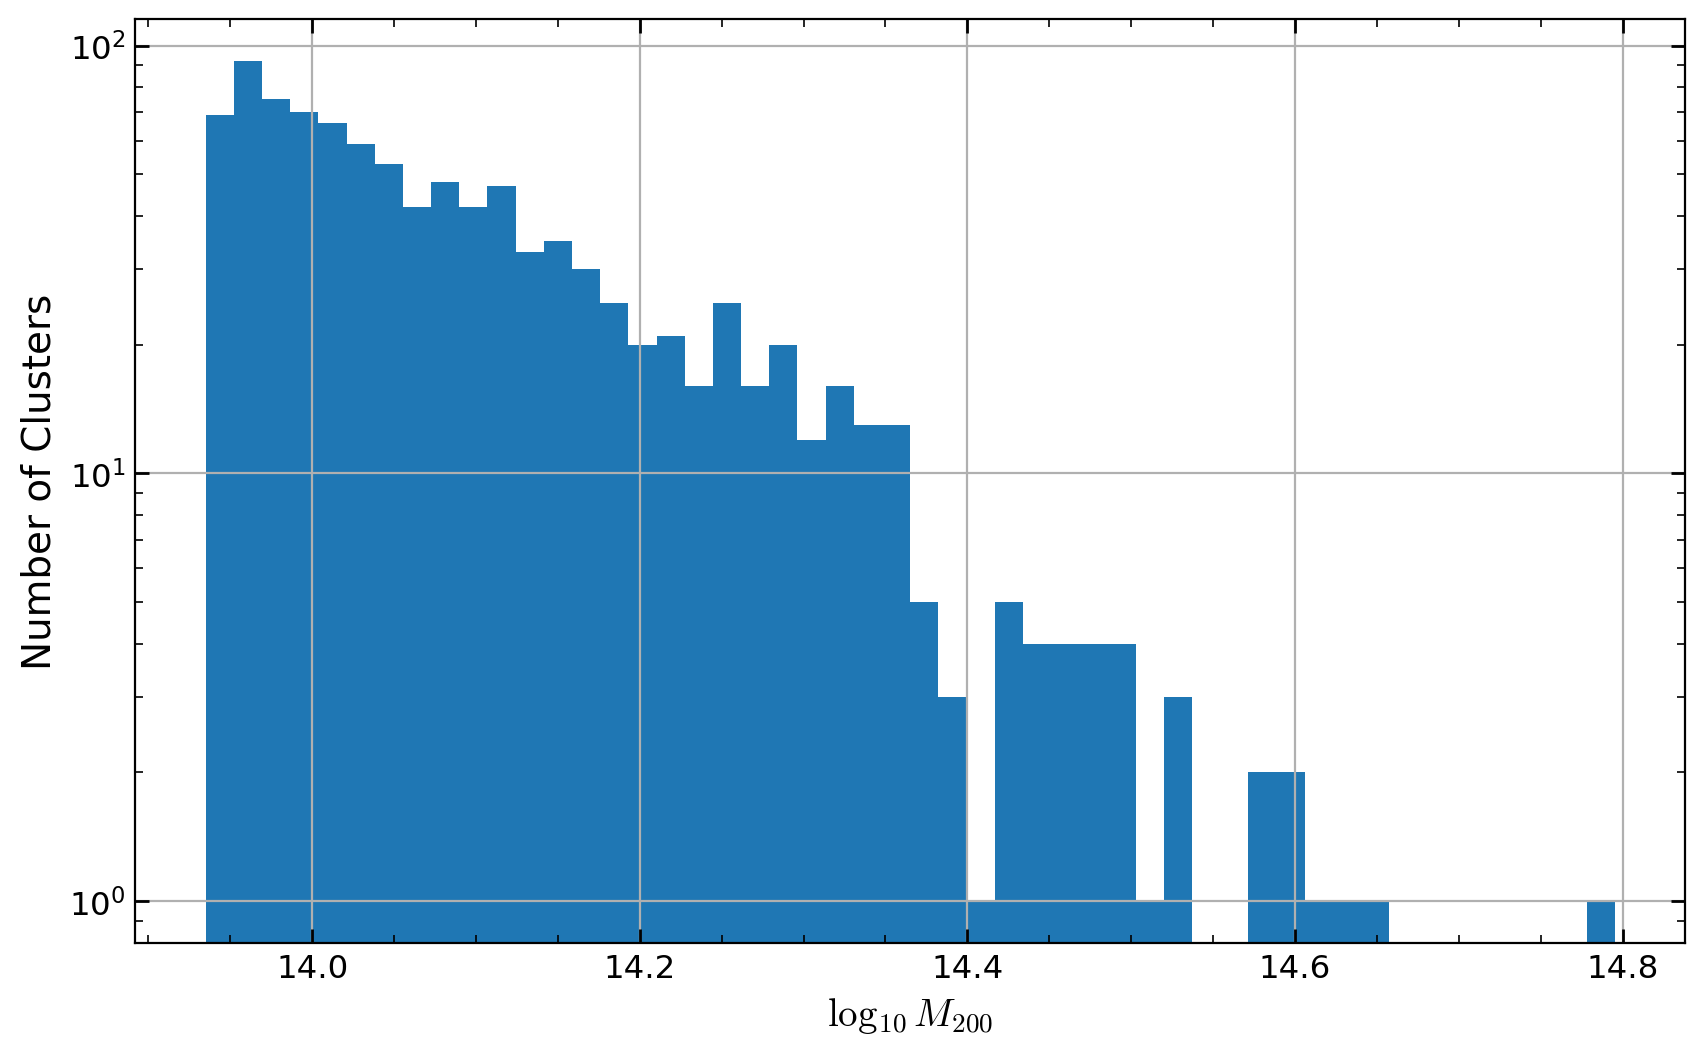

In [13]:
# plot theta distribution
plt.semilogy()
plt.hist(thetas_batch, bins=50)
plt.xlabel(r'$\log_{10} M_{200}$')
plt.ylabel('Number of Clusters');

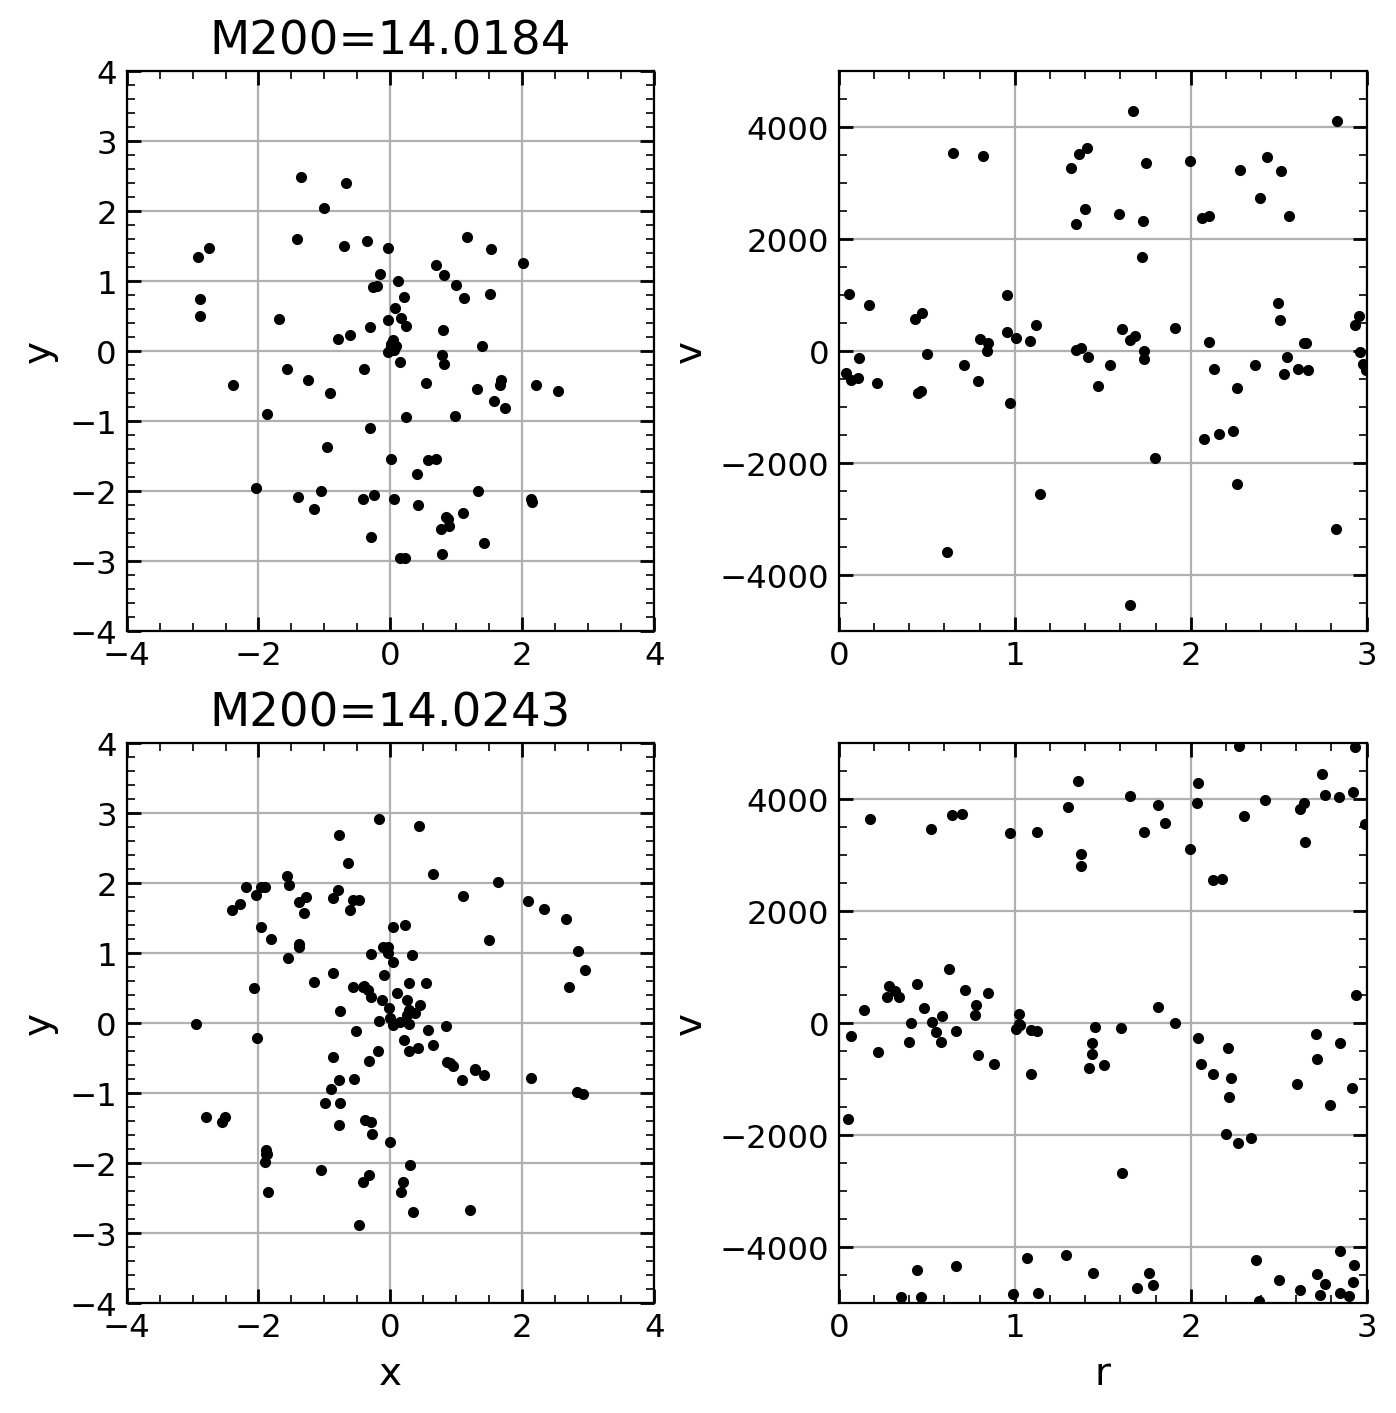

In [14]:
# plot example data
Nex = 2
f, axs = plt.subplots(Nex, 2, figsize=(8,4*Nex),
                      gridspec_kw={'wspace':0.35})
for i in range(Nex):
    ind = np.random.choice(len(x_batch))
    x = x_batch[ind]
    axs[i,0].plot(x[:,0], x[:,1], 'k.')
    axs[i,0].set_ylabel('y')
    axs[i,0].set_xlim(-4,4)
    axs[i,0].set_ylim(-4,4)
    axs[i,0].set_title(f'M200={thetas_batch[ind,0]:.4f}')
    if i==Nex-1:
        axs[i,0].set_xlabel('x')

    axs[i,1].plot(np.sqrt(x[:,0]**2 + x[:,1]**2), x[:,2], 'k.')
    axs[i,1].set_ylabel('v')
    axs[i,1].set_xlim(0,3)
    axs[i,1].set_ylim(-5000,5000)
    if i==Nex-1:
        axs[i,1].set_xlabel('r')
    

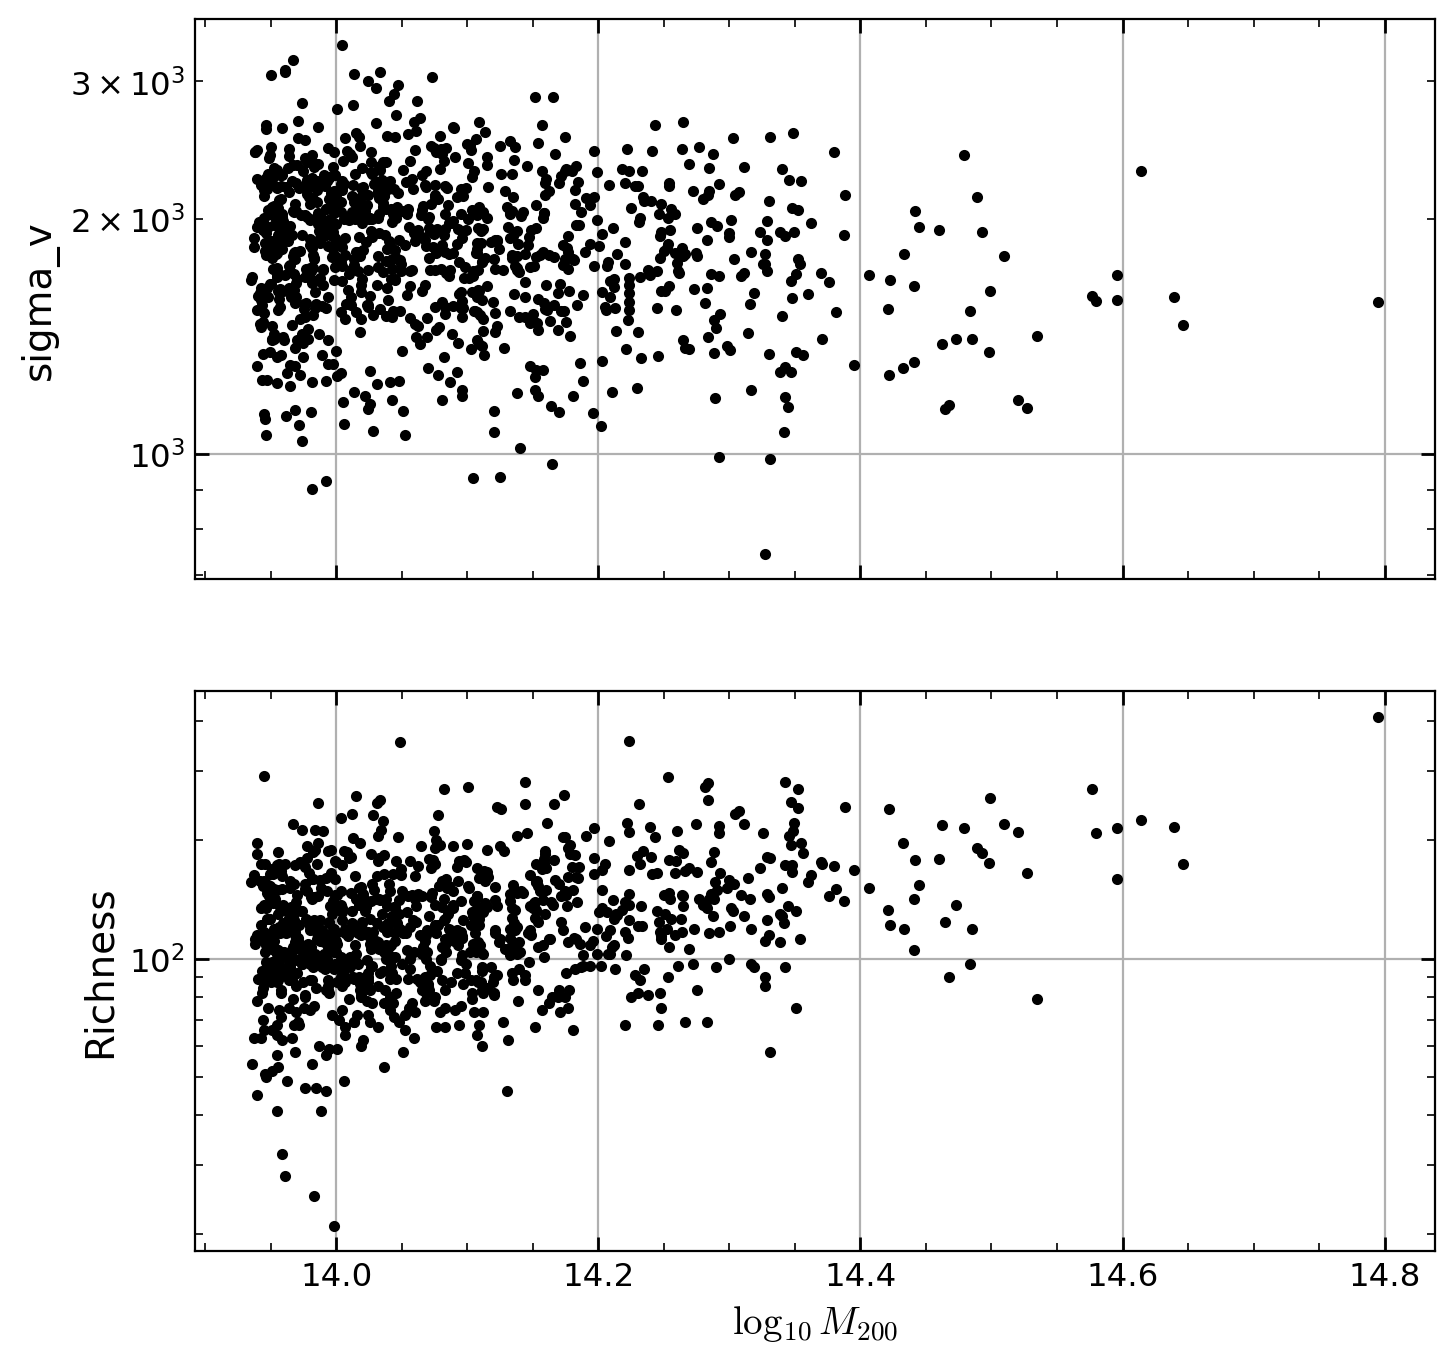

In [15]:
# plot summary relation
f, axs = plt.subplots(2, 1, figsize=(8,8), sharex=True)
axs[0].semilogy()
axs[0].plot(thetas_batch, x_sum[:,8], 'k.')
# axs[0].set_xlabel(r'$\log_{10} M_{200}$')
axs[0].set_ylabel('sigma_v');

axs[1].semilogy()
axs[1].plot(thetas_batch, x_sum[:,-1], 'k.')
axs[1].set_xlabel(r'$\log_{10} M_{200}$')
axs[1].set_ylabel('Richness');

# Andrea Flagship 2 + AMICO (01/02/2024)

In [16]:
data = pd.read_csv(
    'data/raw/deep_all_AMICO.dat', delimiter=' ', index_col=False,
    skipinitialspace=True)
data = pd.DataFrame(
    data.iloc[1:,:-1].values, columns=data.columns[1:]).reset_index(drop=True)

data.head()

/var/folders/_t/p68l7m6933b26j8g9wkcgq080000gp/T/ipykernel_51059/4020439356.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


,xtrue,ytrue,xami,yami,zobs,zwerr,Hmag,fHa,Pmem,M,Comp,Cl_id,zctrue,zcphot,zwC50,zwC100,zdC50,zdC100,M200,r200
0,-0.942,-0.659,-1.023,-0.274,1.314455,1.3157,23.39,-16.185,0.008,0.0,0.99,1001.0,1.57325,1.645,1.64821,1.67512,1.57177,1.64682,9935700000000.0,0.25
1,-1.065,-0.944,-1.146,-0.559,1.312905,1.3172,23.56,-16.17,0.027,0.0,0.38,1001.0,1.57325,1.645,1.64821,1.67512,1.57177,1.64682,9935700000000.0,0.25
2,-0.686,-1.113,-0.767,-0.728,1.322173,1.3221,24.12,-16.244,0.02,0.0,0.87,1001.0,1.57325,1.645,1.64821,1.67512,1.57177,1.64682,9935700000000.0,0.25
3,0.505,-0.248,0.424,0.137,1.359466,1.3621,23.99,-16.179,0.277,0.0,0.64,1001.0,1.57325,1.645,1.64821,1.67512,1.57177,1.64682,9935700000000.0,0.25
4,1.704,-0.62,1.623,-0.236,1.40832,1.4059,22.96,-16.126,0.016,0.0,0.01,1001.0,1.57325,1.645,1.64821,1.67512,1.57177,1.64682,9935700000000.0,0.25


log r200 = 0.36752 log M200 + -5.30640


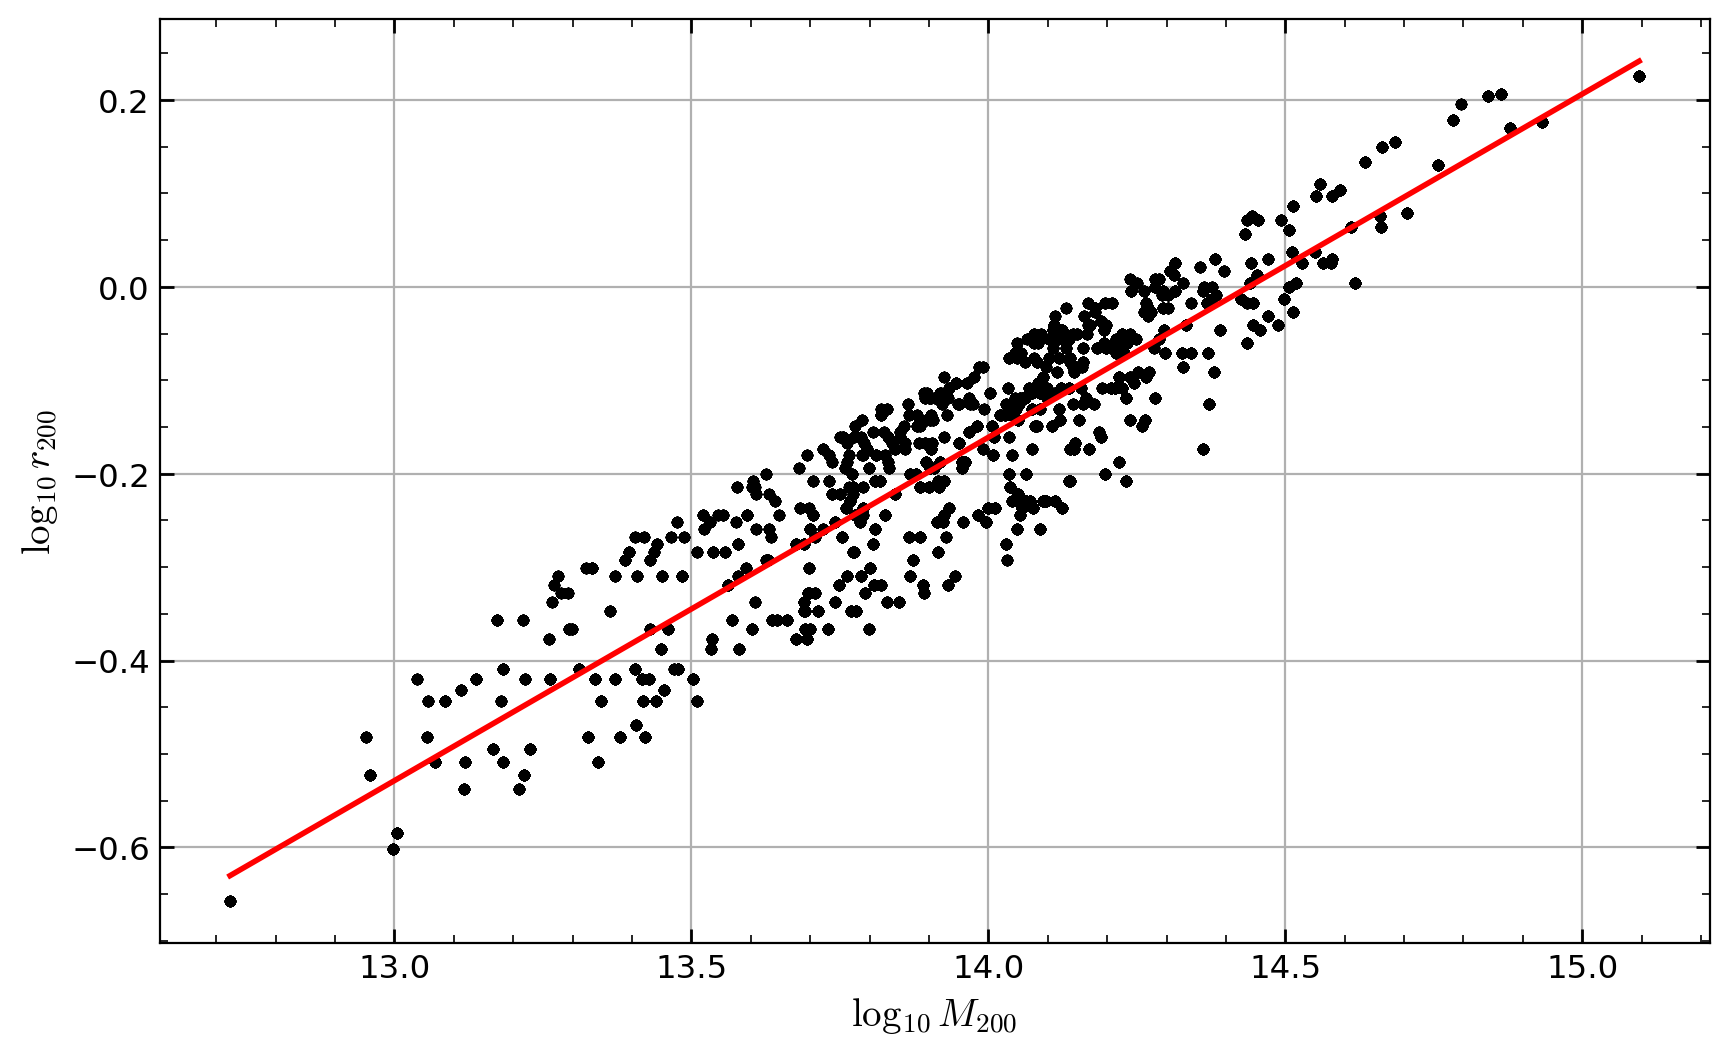

In [6]:
from sklearn.linear_model import LinearRegression

# fit r200-M200 relation
x = np.log10(data['M200'].values.astype(float))
y = np.log10(data['r200'].values.astype(float))

# fit
lr = LinearRegression().fit(x.reshape(-1,1), y)
print(f'log r200 = {lr.coef_[0]:.5f} log M200 + {lr.intercept_:.5f}')

x_ = np.linspace(x.min(), x.max(), 100)
y_ = lr.predict(x_.reshape(-1,1))

plt.plot(x, y, 'k.')
plt.plot(x_, y_, 'r-')
plt.xlabel(r'$\log_{10} M_{200}$')
plt.ylabel(r'$\log_{10} r_{200}$');

In [7]:
c = 2.99792458e5 # km/s
data['vwC50'] = c*(data['zwerr']-data['zwC50'])/(1+data['zwC50'])
data['vwC100'] = c*(data['zwerr']-data['zwC100'])/(1+data['zwC100'])
data['vdC50'] = c*(data['zwerr']-data['zdC50'])/(1+data['zwC50'])
data['vdC100'] = c*(data['zwerr']-data['zdC100'])/(1+data['zwC100'])

In [8]:
# plt.hist(np.unique(np.log10(data['M200'].values.astype('float64'))), 50);
data.columns

Index(['xtrue', 'ytrue', 'xami', 'yami', 'zobs', 'zwerr', 'Hmag', 'fHa',
       'Pmem', 'M', 'Comp', 'Cl_id', 'zctrue', 'zcphot', 'zwC50', 'zwC100',
       'zdC50', 'zdC100', 'M200', 'r200', 'vwC50', 'vwC100', 'vdC50',
       'vdC100'],
      dtype='object')

In [11]:
# TODO: cut on velocities?
# TODO: weight by Pamico?

def calc_sum(x):
    feats = [x.sum(axis=0), x.mean(axis=0), x.std(axis=0),
             np.median(x, axis=0), x.min(axis=0), x.max(axis=0), [len(x)]]
    return np.concatenate(feats)

def process_and_save(
    data,
    survey,
    comp,
    dirpath,
    vmin=5000,
    param_names=['M200'],
):
    # parse arguments
    if survey == 'wide':
        fHa_min = 2e-16
        zrange = (0.9, 1.8)
    elif survey == 'deep':
        fHa_min = 6e-17
        zrange = (0.4, 1.8)
    
    vname = f"v{survey[0]}C{int(comp*100)}"
    zname = f"z{survey[0]}C{int(comp*100)}"
    print(vname, zname)

    # mask out high velocity, low fHa, uncompleted, out-of-bounds data
    mask = np.abs(data[vname]) < vmin
    mask &= data['fHa'] > np.log10(fHa_min)
    mask &= data['Comp'] < comp
    mask &= (data[zname] > zrange[0]) & (data[zname] < zrange[1])

    # get data
    data_names = ['xami','yami',vname,'Pmem']
    ids = data.loc[mask,'Cl_id'].values.astype(int)
    gals = data.loc[mask, data_names].values.astype('float64')
    thetas = np.log10(data.loc[mask, param_names].values.astype('float64'))

    # remove singles
    unq, cnt = np.unique(ids, return_counts=True)
    mask = np.isin(ids, unq[cnt>1])
    ids, gals, thetas = ids[mask], gals[mask], thetas[mask]

    # calculate batches
    ids_batch = np.unique(ids)
    x_batch = np.array([gals[ids==i] for i in ids_batch], dtype=object)
    thetas_batch = np.array([thetas[ids==i][0] for i in ids_batch])

    # calculate summaries
    x_sum = np.array([calc_sum(x) for x in x_batch])


    # assign folds
    np.random.seed(1952)
    folddict = pd.Series(np.random.choice(10, size=len(ids_batch)), 
                         index=ids_batch)
    folds = folddict[ids].values
    folds_batch = folddict[ids_batch].values

    # make train/test splits
    # fold = 0
    # mask = folds != fold

    # save
    os.makedirs(dirpath, exist_ok=True)
    def save(name, arr):
        filepath = join(dirpath, name)
        print(f'saving {filepath}')
        np.save(filepath, arr)

    """
    # Old from when i saved for only one fold
    ## save galwise data
    map(save,
        ['x_train.npy', 'x_test.npy', 'theta_train.npy', 'theta_test.npy', 
         'ids_train.npy', 'ids_test.npy', 'folds.npy'],
        [gals[mask], gals[~mask], thetas[mask], thetas[~mask], 
         ids[mask], ids[~mask], folds]
    )

    ## save clusterwise data
    mask = folddict[ids_batch].values != fold
    map(save,
        ['ids_batch.npy', 'x_batch_train.npy', 'x_batch_test.npy',
         'x_sum_train.npy', 'x_sum_test.npy', 
         'theta_batch_train.npy', 'theta_batch_test.npy'],
        [ids_batch, x_batch[mask], x_batch[~mask],
         x_sum[mask], x_sum[~mask], 
         thetas_batch[mask], thetas_batch[~mask]]
    )
    """
    ## save galwise data
    list(map(save,
        ['x.npy', 'theta.npy', 'ids.npy', 'folds.npy'],
        [gals, thetas, ids, folds]
    ))

    ## save clusterwise data
    list(map(save,
        ['x_batch.npy', 'x_sum.npy', 'theta_batch.npy', 'ids_batch.npy', 'folds_batch.npy'],
        [x_batch, x_sum, thetas_batch, ids_batch, folds_batch]
    ))

    return gals, thetas, x_batch, x_sum, thetas_batch


In [12]:
# Wide survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='wide',
    comp=0.5,
    dirpath='data/processed/AMICOwC50',
)
print(gals.shape)

vwC50 zwC50
saving data/processed/AMICOwC50/x.npy
saving data/processed/AMICOwC50/theta.npy
saving data/processed/AMICOwC50/ids.npy
saving data/processed/AMICOwC50/folds.npy
saving data/processed/AMICOwC50/x_batch.npy
saving data/processed/AMICOwC50/x_sum.npy
saving data/processed/AMICOwC50/theta_batch.npy
saving data/processed/AMICOwC50/ids_batch.npy
saving data/processed/AMICOwC50/folds_batch.npy
(1559, 4)


In [13]:
# Wide survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='wide',
    comp=1,
    dirpath='data/processed/AMICOwC100',
)
print(gals.shape)

vwC100 zwC100
saving data/processed/AMICOwC100/x.npy
saving data/processed/AMICOwC100/theta.npy
saving data/processed/AMICOwC100/ids.npy
saving data/processed/AMICOwC100/folds.npy
saving data/processed/AMICOwC100/x_batch.npy
saving data/processed/AMICOwC100/x_sum.npy
saving data/processed/AMICOwC100/theta_batch.npy
saving data/processed/AMICOwC100/ids_batch.npy
saving data/processed/AMICOwC100/folds_batch.npy
(3062, 4)


In [14]:
# Deep survey, Completeness 50%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='deep',
    comp=0.5,
    dirpath='data/processed/AMICOdC50',
)
print(gals.shape)

vdC50 zdC50
saving data/processed/AMICOdC50/x.npy
saving data/processed/AMICOdC50/theta.npy
saving data/processed/AMICOdC50/ids.npy
saving data/processed/AMICOdC50/folds.npy
saving data/processed/AMICOdC50/x_batch.npy
saving data/processed/AMICOdC50/x_sum.npy
saving data/processed/AMICOdC50/theta_batch.npy
saving data/processed/AMICOdC50/ids_batch.npy
saving data/processed/AMICOdC50/folds_batch.npy
(23866, 4)


In [15]:
# Deep survey, Completeness 100%
gals, thetas, x_batch, x_sum, thetas_batch = process_and_save(
    data,
    survey='deep',
    comp=1,
    dirpath='data/processed/AMICOdC100',
)
print(gals.shape)

vdC100 zdC100
saving data/processed/AMICOdC100/x.npy
saving data/processed/AMICOdC100/theta.npy
saving data/processed/AMICOdC100/ids.npy
saving data/processed/AMICOdC100/folds.npy
saving data/processed/AMICOdC100/x_batch.npy
saving data/processed/AMICOdC100/x_sum.npy
saving data/processed/AMICOdC100/theta_batch.npy
saving data/processed/AMICOdC100/ids_batch.npy
saving data/processed/AMICOdC100/folds_batch.npy
(46217, 4)


13.940800364230586 0.37279120593766824


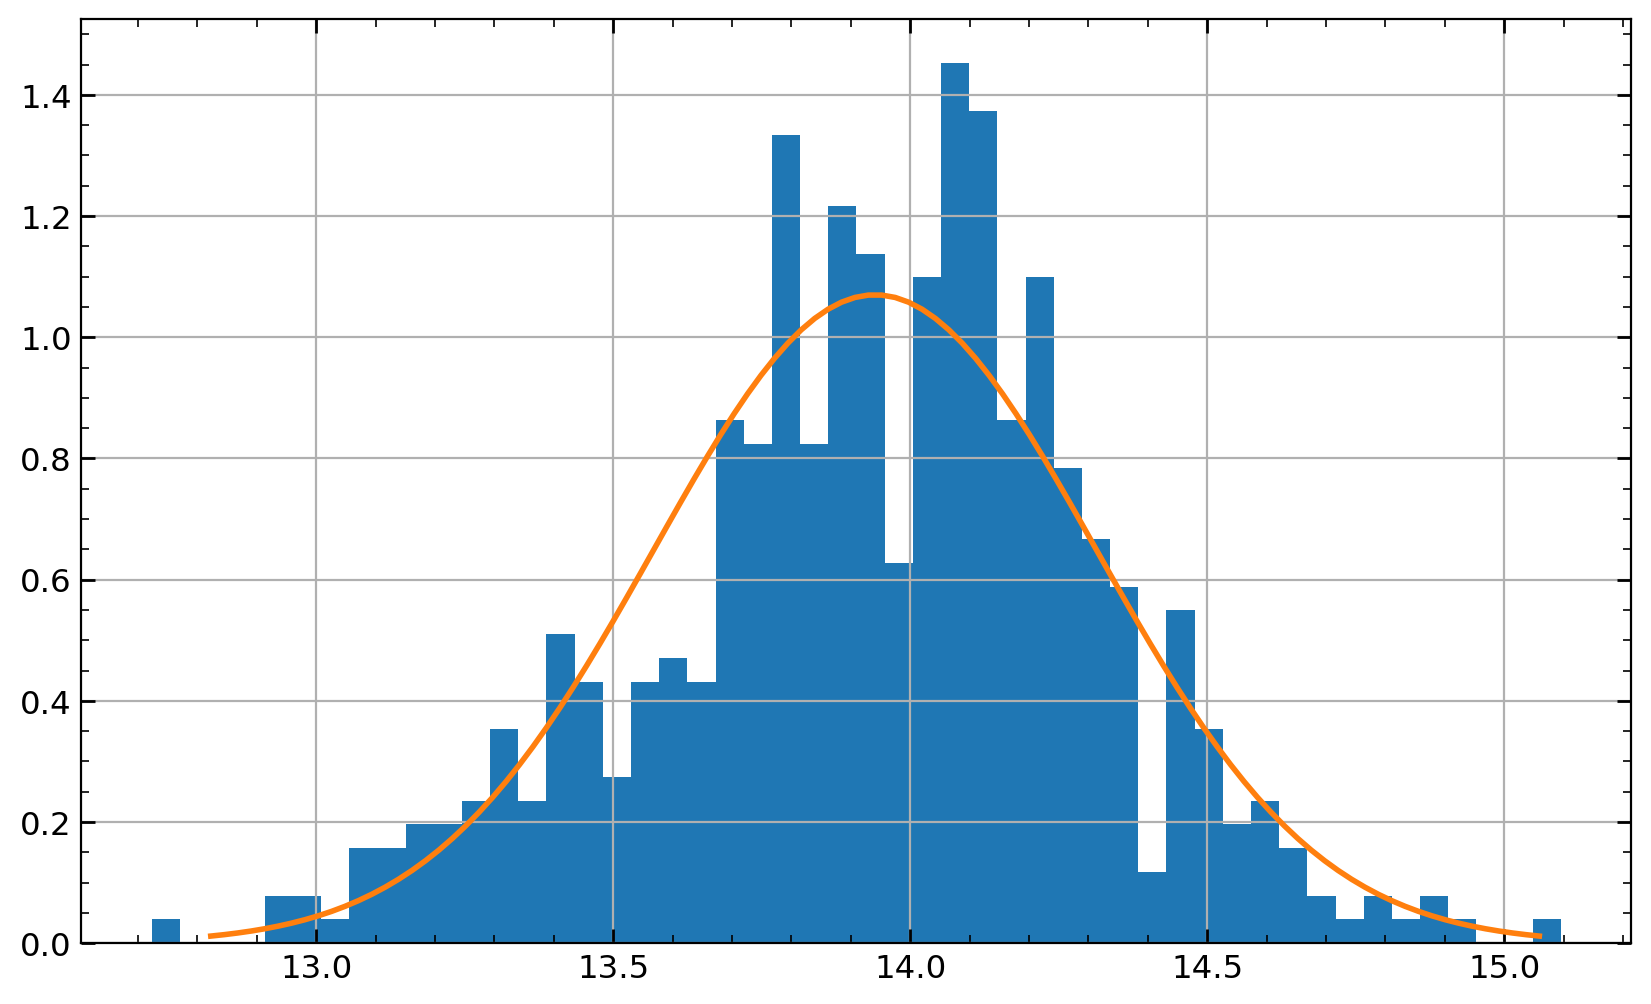

In [14]:
from scipy.stats import norm
mu, sig = np.mean(thetas_batch), np.std(thetas_batch)
plt.hist(thetas_batch, bins=50, density=True);
x_ = np.linspace(mu-3*sig, mu+3*sig, 100)
plt.plot(x_, norm.pdf(x_, mu, sig));
print(mu, sig)